### Testing maskgalaxies


In [13]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from scipy.ndimage import morphology
from skimage import morphology as skimagemorphology

import get_halpha_SB

import eagleSqlTools as sql

%matplotlib inline

In [14]:
%run 'load_data.ipynb'
%run 'add_noise.ipynb'
%run 'extract_FOV.ipynb'
%run 'mask_galaxies.ipynb'

In [3]:
machine = 'chinook'
slicewidth = 20.; resolution = None; distance   = '100Mpc';
data_tuple = loaddata(machine=machine, distance=distance, slicewidth=slicewidth)  ### I want this to set the resolution too

Resolution is None, finding minimum resolution of the similuation...
The resolution of the raw simulation at 100Mpc is 6.40094057981.
Loading data of slicewidth 20 (after rounding), number of slices is 4
./intermediatedata/data_100Mpc_6arcsec_20slwd.npz exists, loading now...
./intermediatedata/data_100Mpc_6arcsec_20slwd.npz was not saved as a tuple since too large, returning as tuple with 32000,1 appended.


In [4]:
resolution = 6.4 ### PUT THIS IN MANUALLY FROM THE OUTPUT OF data_tuple
data_tuple[0].shape

(32000, 32000)

In [5]:
data_FOV, xystarts, size = extractFOV(data_tuple,resolution,distance,x_center=50.5,y_center=13.5)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


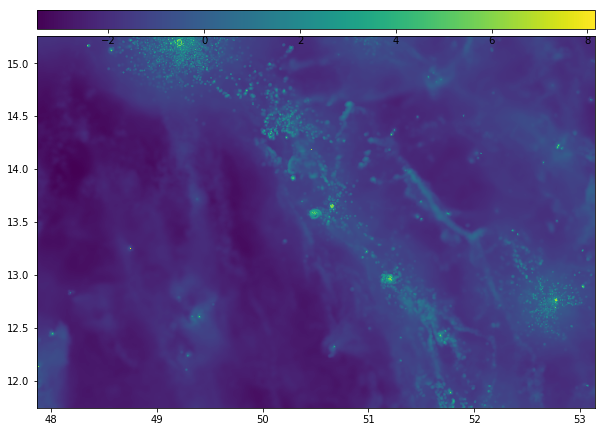

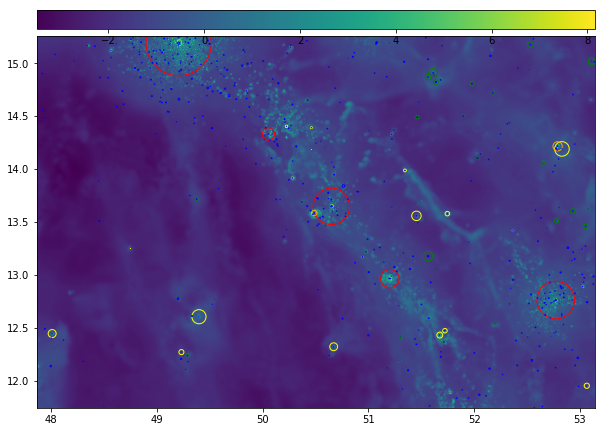

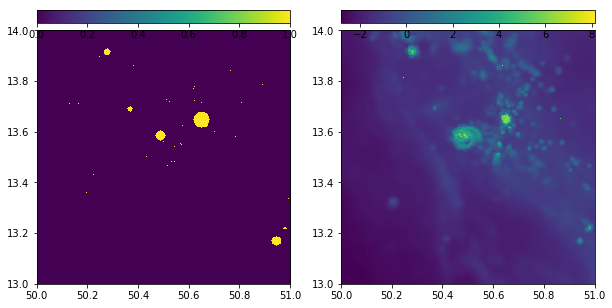

In [8]:
masked_data = maskgalaxies(data_FOV,xystarts,size,slicewidth,distance,resolution,debug=False,verbose=False)

The blue circles are the stellar half-mass radii.  The coloured circles are the gas half-mass radii.  It looks like the stellar halos are quite distinct from the gaseous halos for the lower mass galaxies (e.g. dwarf galaxies).  This seems to imply that, at least as redshift zero, the gas accretes independantly onto the galaxies from the stars.

In [9]:
print data_FOV.shape
print masked_data.data.shape

(1688, 1124)
(1688, 1124)


Will set mask to False since masking is set to False.
Output grid must have a integer number of cells: trimming the array down to satisfy this.
Before reducing resolution, the original array was trimmed from size 1688,1124 to size 1680,1110.
Before reducing resolution, the original array was trimmed from size 1688,1124 to size 1680,1110.
Output grid must have a integer number of cells: trimming the array down to satisfy this.
Before reducing resolution, the original array was trimmed from size 1688,1124 to size 1680,1110.
Before reducing resolution, the original array was trimmed from size 1688,1124 to size 1680,1110.


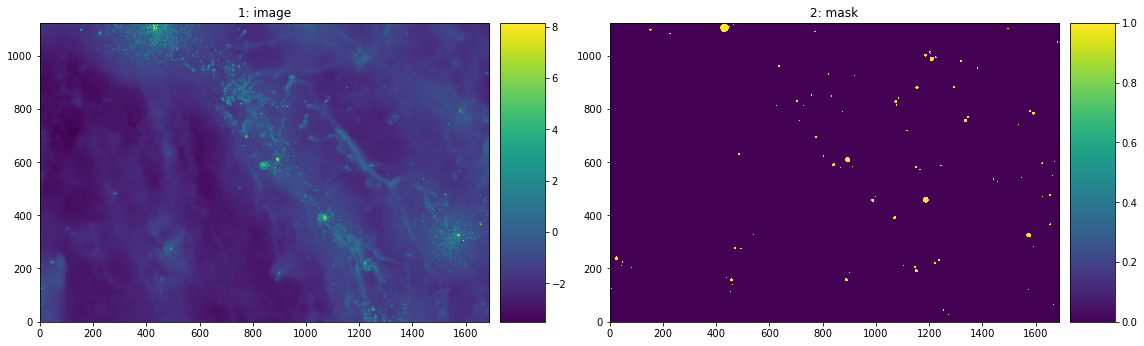

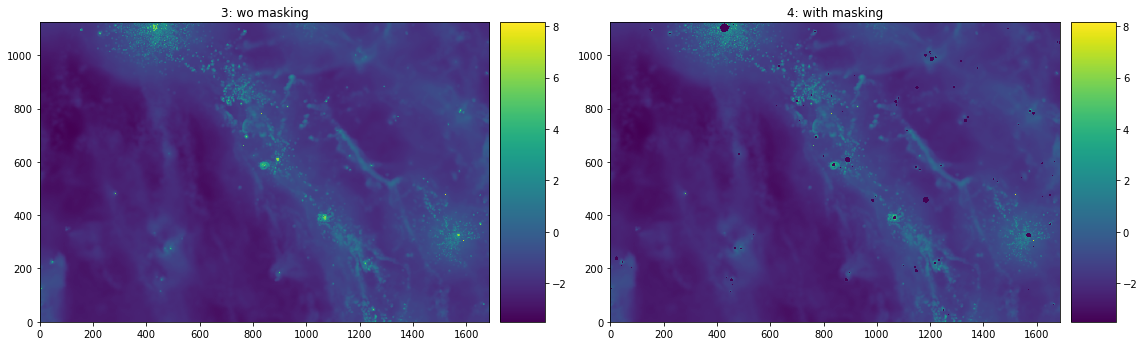

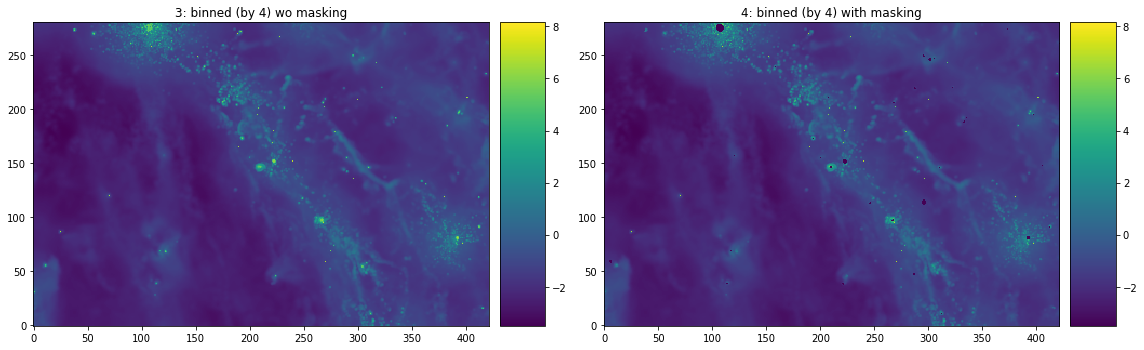

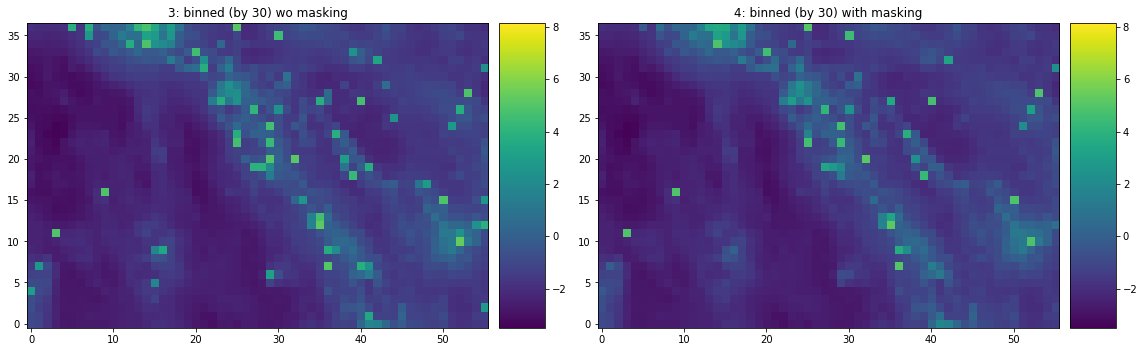

In [12]:
bounds = [np.max(masked_data.data),np.min(masked_data.data)]

# Plot the full res data and mask of that
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
plotdata(masked_data.data.T,ax=ax1,colorbar=True,bounds=bounds)
ax1.set_title('1: image')
plotdata(masked_data.mask.T,ax=ax2,colorbar=True)
ax2.set_title('2: mask')
plt.tight_layout()

factor = 1

# Plot the data (wo mask) and data (w mask)
lowres = get_halpha_SB.imreduce(masked_data.data, factor, log=True, method = 'average') 
lowres_masked, mask, fillvalue = imreduce_masked(masked_data.data,factor,mask=masked_data.mask,log=True,fillby='min')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
plotdata(lowres.T,ax=ax1,colorbar=True,bounds=bounds)
ax1.set_title('3: wo masking')
plotdata(lowres_masked.T,ax=ax2,colorbar=True,bounds=bounds)
ax2.set_title('4: with masking')
plt.tight_layout()
    
factor = 4

# Plot the binned data (wo mask) and binned data (w mask)
lowres = get_halpha_SB.imreduce(masked_data.data, factor, log=True, method = 'average') 
lowres_masked, mask, fillvalue = imreduce_masked(masked_data.data,factor,mask=masked_data.mask,log=True,fillby='min')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
plotdata(lowres.T,ax=ax1,colorbar=True,bounds=bounds)
ax1.set_title('3: binned (by 4) wo masking')
plotdata(lowres_masked.T,ax=ax2,colorbar=True,bounds=bounds)
ax2.set_title('4: binned (by 4) with masking')
plt.tight_layout()

factor = 30

# Plot the binned data (wo mask) and binned data (w mask)
#lowres = get_halpha_SB.imreduce(masked_data.data, factor, log=False, method = 'average') 
lowres, mask_none, fillvalue_none = imreduce_masked(masked_data.data, factor, log=True, masking=False) 
lowres_masked, mask, fillvalue = imreduce_masked(masked_data.data,factor,mask=masked_data.mask,log=True,fillby='min')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
plotdata(lowres.T,ax=ax1,colorbar=True,bounds=bounds)
ax1.set_title('3: binned (by 30) wo masking')
plotdata(lowres_masked.T,ax=ax2,colorbar=True,bounds=bounds)
ax2.set_title('4: binned (by 30) with masking')
plt.tight_layout()



Some notes:

- These above plots are all binned in linear space (e.g. as if doing on-chip binning)
- Looks like these weird points dont disappear with the masking, and they end up super noticeable even when binning.  Is this true or is it that the bins are in the wrong place?  Taking a look at the plot with the circles corresponding to half-mass gas and stellar radii, it looks like the masking is fine - but since masking based on stellar half-mass radii, will not always line up with "dark clouds" of hydrogen.